# Clasificador Bayesiano LDA

Ejercicio 1: Clasificador Bayesiano LDA. \
**16.32 - Redes Neuronales en Bioingeniería - Comisión: BIO**\
20251Q

61522 - Bouzo, Sofía\
61649 - Fernández, Martín

In [30]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


In [2]:
N=-1

In [3]:
data = pd.read_csv('data/alturas-pesos-mils-train.csv')[:N]
test = pd.read_csv('data/alturas-pesos-mils-test.csv')

In [4]:
data_hombres = data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres = data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values

## Primera visualización de la dispersión de datos

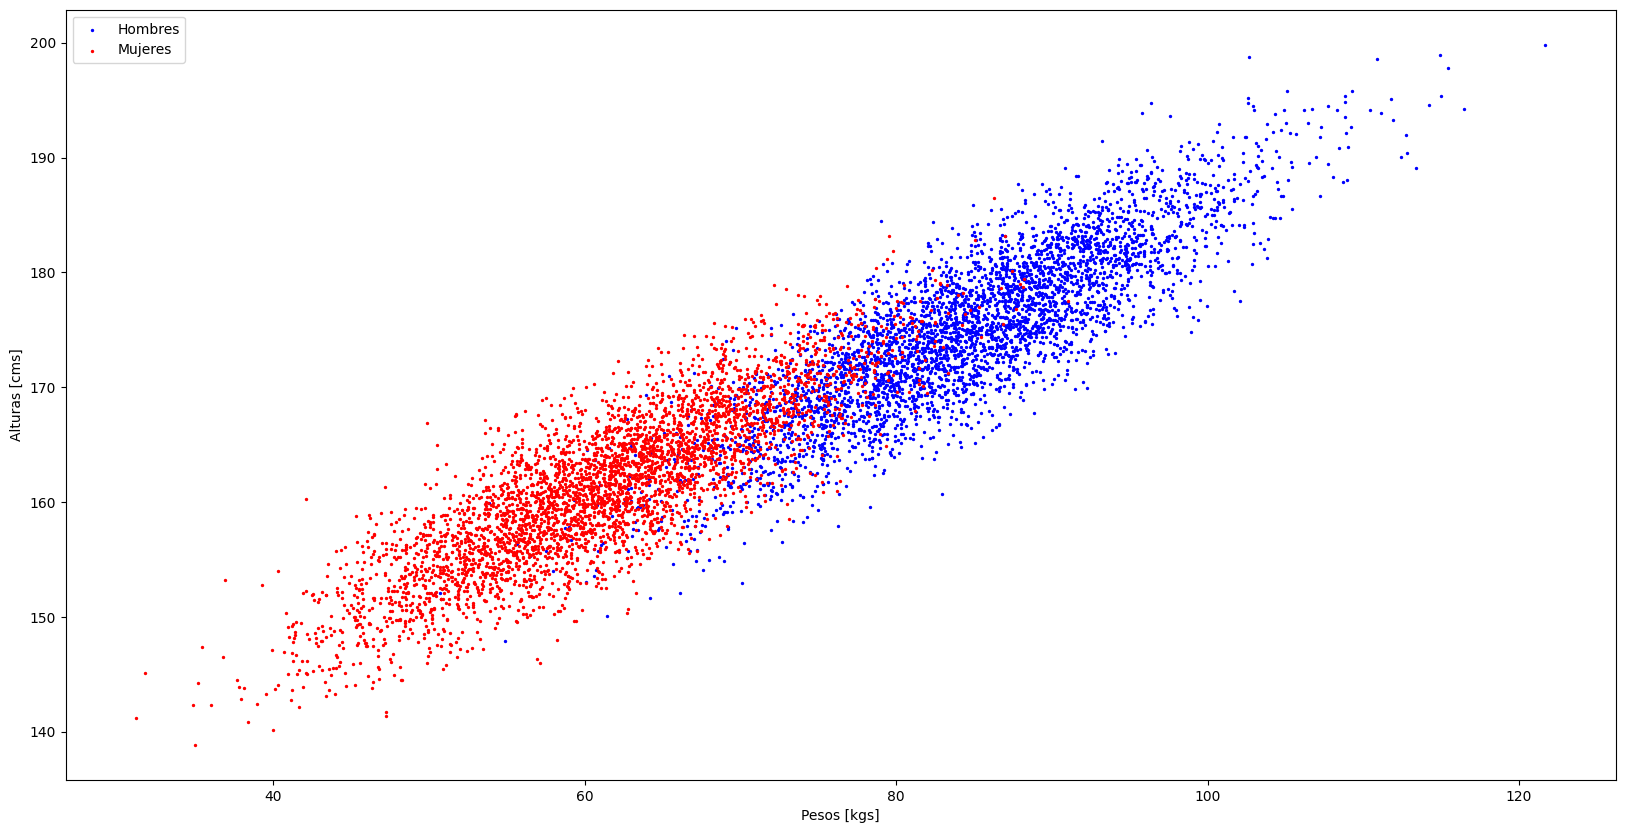

In [5]:
%matplotlib inline
f = plt.figure(figsize=(20,10))
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, label='Hombres')
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, label='Mujeres')
plt.xlabel('Pesos [kgs]')
plt.ylabel('Alturas [cms]')
plt.legend()
plt.show()

Se calcula la media del peso y altura para cada clase y la matriz de covarianza, que por usar el algoritmo de LDA se asumen iguales entre clases.

In [6]:
peso_altura_hombres = data.loc[data['Genero']=='Hombre'][['Peso', 'Altura']].values
peso_altura_mujeres = data.loc[data['Genero']=='Mujer'][['Peso', 'Altura']].values

mean_hombres = peso_altura_hombres.mean(axis=0)
mean_mujeres = peso_altura_mujeres.mean(axis=0)
cov_LDA = np.cov(np.vstack([peso_altura_hombres - mean_hombres, peso_altura_mujeres - mean_mujeres]).T)

La siguiente función calcula la probabilidad de cada clase según los valores de peso y altura:
- *multivariate_normal.pdf()* calcula la verosimilitud de que los datos pertenezca a la clase, con distribución normal multivariada (simil a probabilidad de observar los datos dado que pertenecen a una clase específica.)
- *p_class* calcula la probabilidad posterior de cada clase dado el valor de datos de entrada por Bayes, es decir, la probabilidad de pertenecer a cada clase dado un valor específico de peso y altura

In [7]:
def get_gauss_prob(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_hombres, cov_hombres)
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_mujeres, cov_mujeres)
    N_class_1 = len(peso_altura_hombres)
    N_class_2 = len(peso_altura_mujeres)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    return p_class_1, p_class_2

*get_acc_gauss()* devuelve la accuracy del clasificador bayesiano comparando las probabilidades pbtenidas con la función anterior con la verdadera etiqueta para ese conjunto de datos y sumando los verdaderos positivos para luego dividirlos por la cantidad de datos

In [8]:
def get_acc_gauss(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    p_class_1, p_class_2 = get_gauss_prob(data[['Peso', 'Altura']].values, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)
    return ((p_class_1>p_class_2)==(data['Genero']=='Hombre')).sum()/len(data)

In [9]:
acc_train_LDA =  get_acc_gauss(data, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)
print(f"Accuracy del set de entrenamiento para LDA: {acc_train_LDA}")
acc_test_LDA = get_acc_gauss(test, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)
print(f"Accuracy del set de test para LDA:{acc_test_LDA}")

Accuracy del set de entrenamiento para LDA: 0.9167395924490561
Accuracy del set de test para LDA:0.9225


In [10]:
N = 300
X = np.linspace(data.min()['Peso'], data.max()['Peso'], N)
Y = np.linspace(data.min()['Altura'], data.max()['Altura'], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z_H_LDA = multivariate_normal.pdf(pos, mean_hombres, cov_LDA)
Z_M_LDA = multivariate_normal.pdf(pos, mean_mujeres, cov_LDA)
Z_LDA, _ = get_gauss_prob(pos, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)

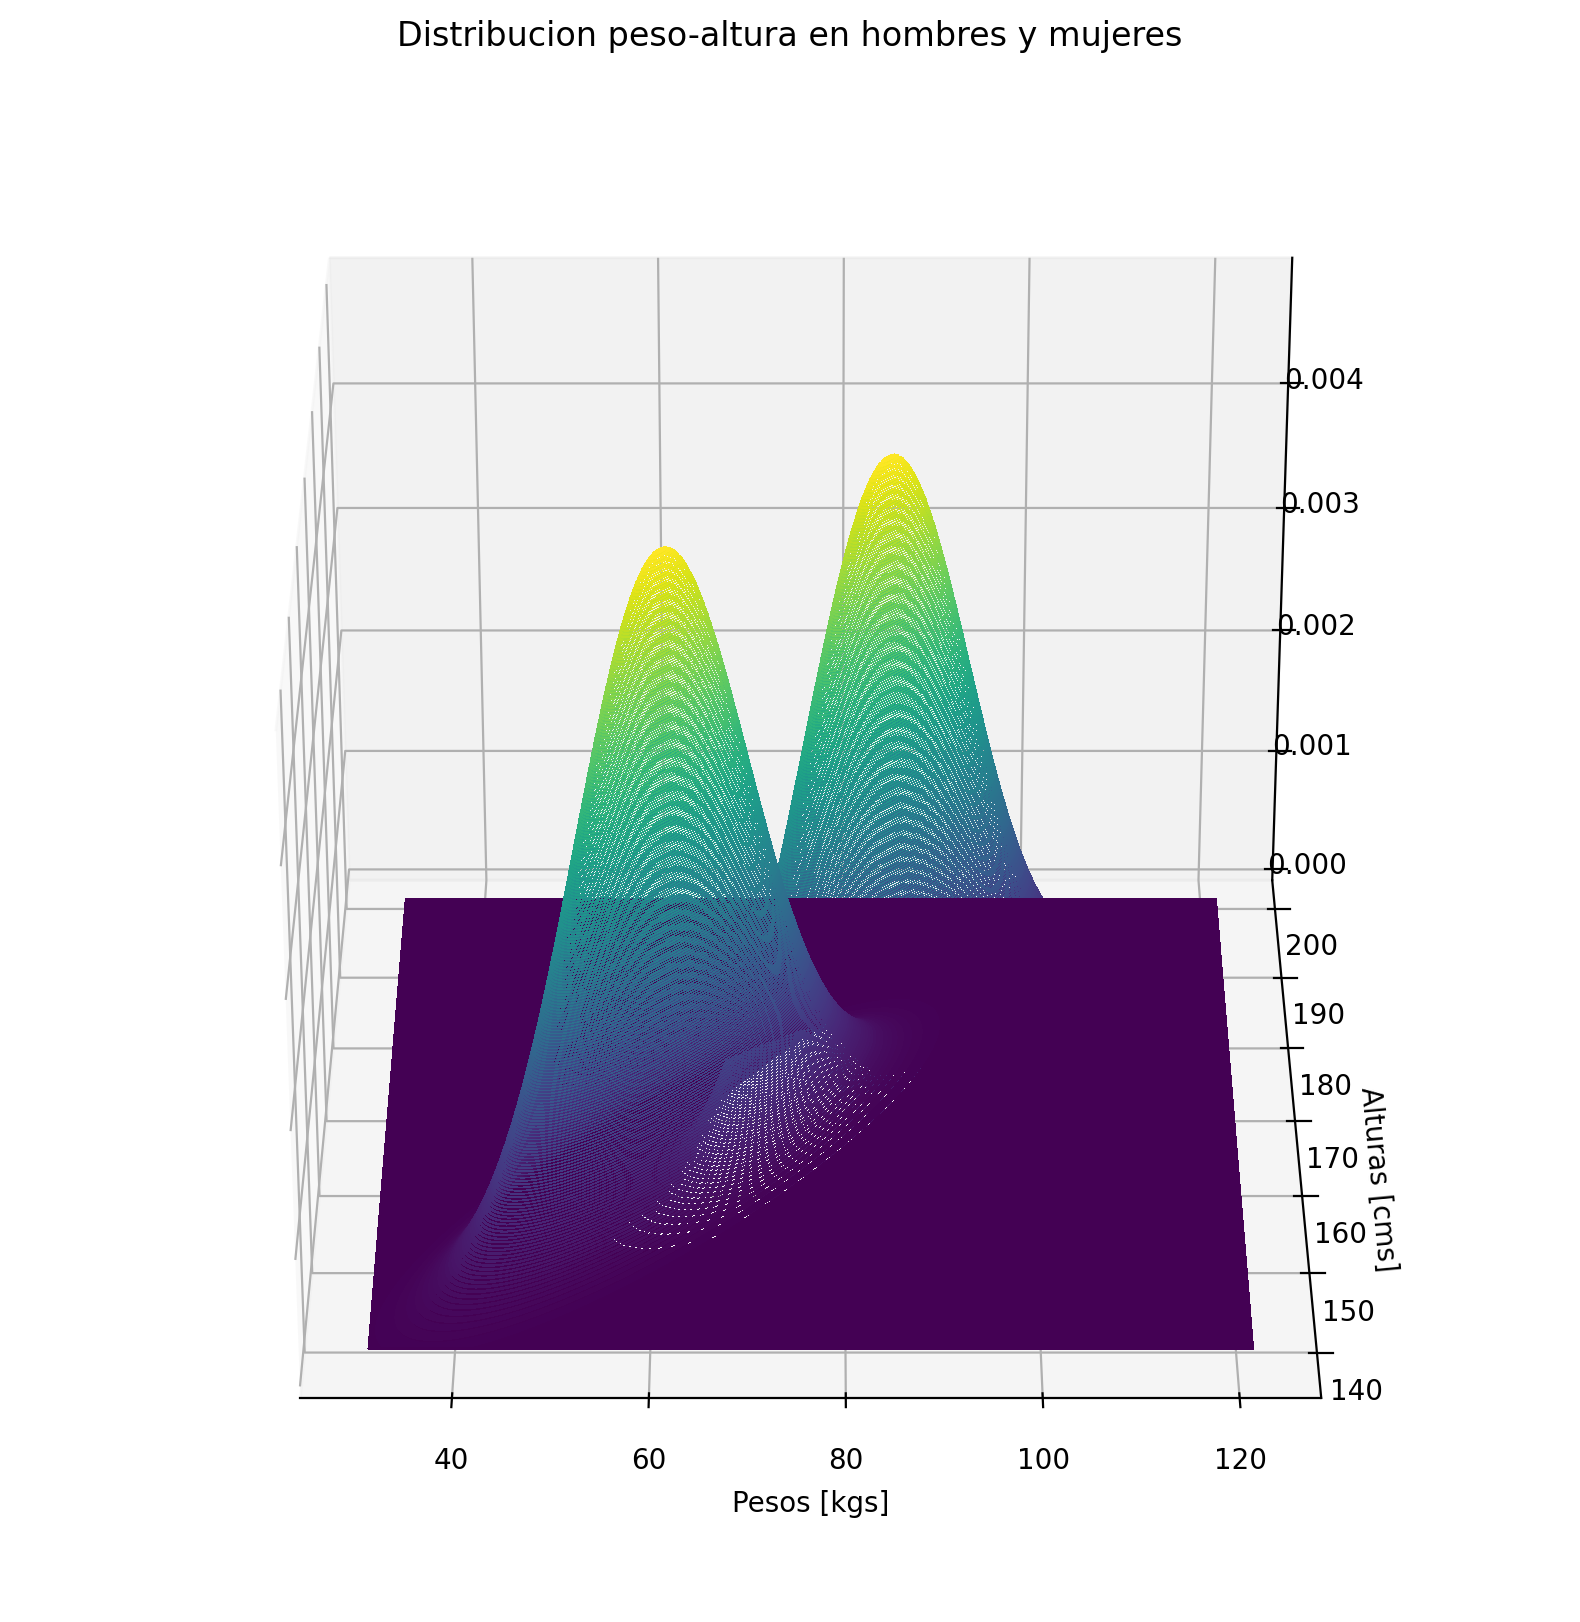

In [33]:
%matplotlib inline
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')  # Cambié esta línea
cm = plt.cm.RdBu
#cf = ax.contourf(X, Y, Z, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
#plt.colorbar(cf, ax=ax)
ax.contourf(X, Y, Z_H_LDA, 256)
ax.contourf(X, Y, Z_M_LDA, 256)
ax.view_init(30, -90) 
ax.set_title('Distribucion peso-altura en hombres y mujeres')
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.show()


### Umbral de decisión

Para hallar la fórmula del umbral de decisión, a partir de Log-Odds y con operaciones algebraicas, se llega a la siguiente ecuación:


$$
X^T W + C = 0
$$

donde W y C son combinacion de las medias y la inversa de la matriz de covarianza. De aqui resulta que la forma del umbral de decisión en este caso se trata de una recta y etso mismo se puede ver graficamente:

In [12]:
W = np.linalg.inv(cov_LDA).dot(mean_hombres - mean_mujeres)
C = np.log(peso_altura_hombres.shape[0]/peso_altura_mujeres.shape[0]) - 0.5*(mean_hombres + mean_mujeres).T.dot(np.linalg.inv(cov_LDA)).dot(mean_hombres - mean_mujeres) 
# Verificación ecuación
z_teorica = np.zeros([N, N])
for row in range(pos.shape[0]):
    for col in range(pos.shape[1]):
        z_teorica[row, col] = pos[row, col].T.dot(W) + C

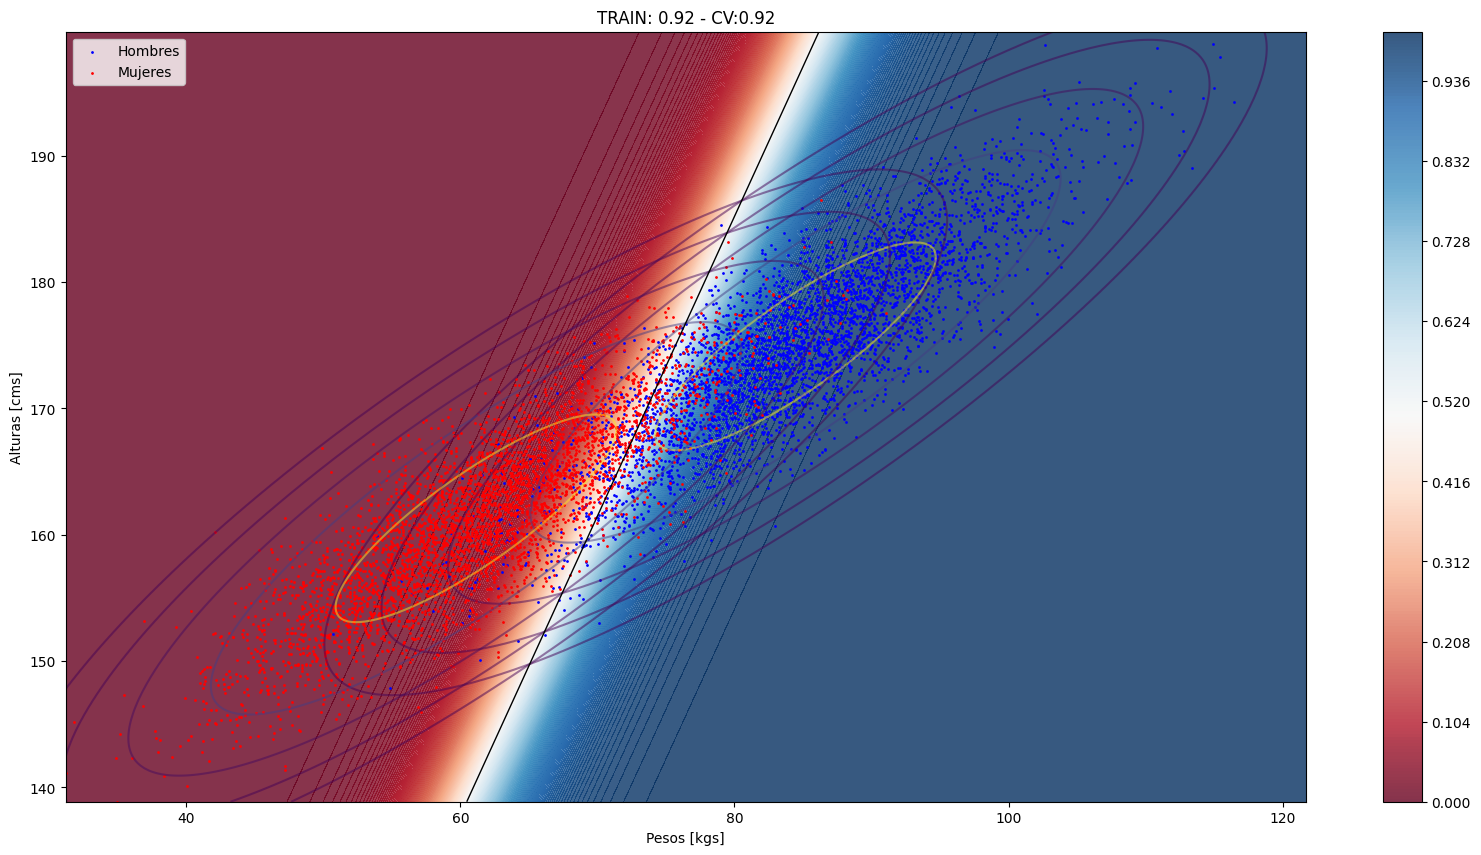

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_LDA, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
z_levels = np.logspace(-5,-2,5)/4
ax.contour(X, Y, Z_H_LDA, z_levels, alpha=0.5)
ax.contour(X, Y, Z_M_LDA, z_levels, alpha=0.5)
ax.contour(X, Y, Z_LDA, (0.5,), colors='k', linewidths=1) #umbral de decisión
ax.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=1, label='Hombres')
ax.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=1, label='Mujeres')
ax.set_title('TRAIN: ' + str(np.round(acc_train_LDA*100)/100) + ' - CV:' + str(np.round(acc_test_LDA*100)/100))
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.legend()
plt.show()

La recta negra que atravieza la intersección de todas las curvas de nivel representa el umbral de decisión.

## LDA de sklearn

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [16]:
Y_train = data.loc[:, 'Genero']
Y_test= test.loc[:, 'Genero']
X_train = data.loc[:,['Peso',"Altura"]]
X_test = test.loc[:,['Peso',"Altura"]]

Realizamos las mismas pruebas con la librería de sklearn y comparamos con los resultados obtenidps manualmente:

In [17]:
clf= LinearDiscriminantAnalysis(store_covariance= True)
clf.fit(X_train, Y_train)
clf.predict(X_test)
clf.predict_proba(X_test)
clf.decision_function(X_test)


array([-5.62999762,  4.31388979,  2.77784501, ...,  6.31213084,
       -3.3644751 ,  4.04159579], shape=(2000,))

### Métricas

In [18]:
train_accuracy = clf.score(X_train, Y_train)

test_accuracy = clf.score(X_test, Y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 0.9167
Test Accuracy: 0.9225


### Parámetros

En este caso tenemos 2 parámetros de entrada:

In [19]:
print(f"Media con LinearDiscriminantAnalysis de sklearn : {clf.means_} \n Matriz de covarianza con LinearDiscriminantAnalysis de sklearn: {clf.covariance_} \n Factor Pesos W: {clf.coef_}\n Factor Constante C: {clf.intercept_}")

Media con LinearDiscriminantAnalysis de sklearn : [[ 84.45643089 174.91616521]
 [ 61.13789495 161.30471261]] 
 Matriz de covarianza con LinearDiscriminantAnalysis de sklearn: [[77.93622815 53.52300796]
 [53.52300796 50.29019005]] 
 Factor Pesos W: [[-0.42102039  0.17749442]]
 Factor Constante C: [0.80967443]


In [20]:
print(f" Media del algoritmo manual: {mean_hombres, mean_mujeres} \n Matriz de covarianza del algoritmo manual: {cov_LDA} \n Factor Pesos W: {W}\n Factor Constante C: {C}")

 Media del algoritmo manual: (array([ 84.45643089, 174.91616521]), array([ 61.13789495, 161.30471261])) 
 Matriz de covarianza del algoritmo manual: [[77.94597261 53.52970001]
 [53.52970001 50.2964779 ]] 
 Factor Pesos W: [ 0.42107303 -0.17751662]
 Factor Constante C: -0.8097757716405799


Se puede observar que en ambos algoritmos los parámetros dan muy similares, del orden de 10^-4. Sin embargo, para los valores de C y W los signos se encuentran invertidos.

## Extensión cuadrática

In [21]:
peso = data["Peso"].to_numpy() 
altura = data["Altura"].to_numpy()

X_train_quad = np.column_stack([
    peso,
    peso**2,
    altura,
    altura**2,
    peso * altura
])

peso = test["Peso"].to_numpy() 
altura = test["Altura"].to_numpy()

X_test_quad = np.column_stack([
    peso,
    peso**2,
    altura,
    altura**2,
    peso * altura
])

In [ ]:
clf_quad=LinearDiscriminantAnalysis(solver='lsqr')
clf_quad.fit(X_train_quad,Y_train)
clf_quad.predict(X_test_quad)


array(['Hombre', 'Mujer', 'Mujer', ..., 'Mujer', 'Hombre', 'Mujer'],
      shape=(2000,), dtype='<U6')

### Umbral de decisión

Ahora trabajamos con 5 parámetros y al aplicar los pasos de Log-Odds la solución no es más una linea recta ya que resulta en un polinomio cuadrático de dos variables:



$$
w_1 p + w_2 p^2 + w_3 a + w_4 a^2 + w_5 (p \cdot a) + b = 0
$$

Al resolver esta ecuación recuparamos el umbral de decisión que puede tomar distintas formas según los valores de los w y permite describir relaciones no lineales que pueden existir entre peso y altura que son ignoradas en el caso estandar.

In [31]:
print(f"Wext: {clf_quad.coef_} \n Cext: {clf_quad.intercept_}")

Wext: [[-1.15043947 -0.0013536   1.29698478 -0.00452557  0.0055109 ]] 
 Cext: [-66.66547674]


### Parámetros

Como ya mencionamos, en el caso de la extensión cuadrática trabajamos con 5 parámetros que coincide con la dimensión de la matriz de covarianza y la media:

In [34]:
clf_quad.means_

array([[   84.45643089,  7213.57908856,   174.91616521, 30648.6844341 ,
        14829.07457073],
       [   61.13789495,  3813.02221877,   161.30471261, 26066.76905825,
         9912.59496949]])

In [23]:
clf_quad.covariance_

array([[7.79362281e+01, 1.14344142e+04, 5.35230080e+01, 1.80343081e+04,
        1.70601832e+04],
       [1.14344142e+04, 1.73214703e+06, 7.86804832e+03, 2.67372342e+06,
        2.53934154e+06],
       [5.35230080e+01, 7.86804832e+03, 5.02901901e+01, 1.69391090e+04,
        1.27106655e+04],
       [1.80343081e+04, 2.67372342e+06, 1.69391090e+04, 5.71970206e+06,
        4.30052326e+06],
       [1.70601832e+04, 2.53934154e+06, 1.27106655e+04, 4.30052326e+06,
        3.83317663e+06]])

### Métricas

In [24]:
train_accuracy = clf_quad.score(X_train_quad, Y_train)

test_accuracy = clf_quad.score(X_test_quad, Y_test)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9157
Test Accuracy: 0.9200


Tanto el accuracy para el conjunto de entrenamiento y validación son muy similares al caso del LDA estandar aunque levemente inferiores. Si bien este método permite recuperar relaciones no lineales entre peso y altura parece que estas no ayudan a describir mejor la realidad.

# Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
logR = LogisticRegression(C=1e12)
logR.fit(X_train, Y_train)
logR.predict(X_test)

array(['Hombre', 'Mujer', 'Mujer', ..., 'Mujer', 'Hombre', 'Mujer'],
      shape=(2000,), dtype=object)

### Métricas

In [27]:
train_accuracy = logR.score(X_train, Y_train)

test_accuracy = logR.score(X_test, Y_test)

print(f"Train Accuracy de Logistic Regression: {train_accuracy:.4f}")
print(f"Test Accuracy de Logistic Regression: {test_accuracy:.4f}")

Train Accuracy de Logistic Regression: 0.9166
Test Accuracy de Logistic Regression: 0.9220


Se puede observar que la accuracy de este método es levemente mejor que la del LDA.

### Umbral de decisión

Los parámetros son:

In [38]:
print(f"W: {logR.coef_} \n C: {logR.intercept_}")

W: [[-0.42864249  0.18550112]] 
 C: [0.00347462]


In [ ]:
N = 300
X = np.linspace(data.min()['Peso'], data.max()['Peso'], N)
Y = np.linspace(data.min()['Altura'], data.max()['Altura'], N)
X, Y = np.meshgrid(X, Y)

Z_lr = logR.predict_proba(np.c_[X.ravel(), Y.ravel()])[:, 0]

Z_lr = Z_lr.reshape(X.shape)

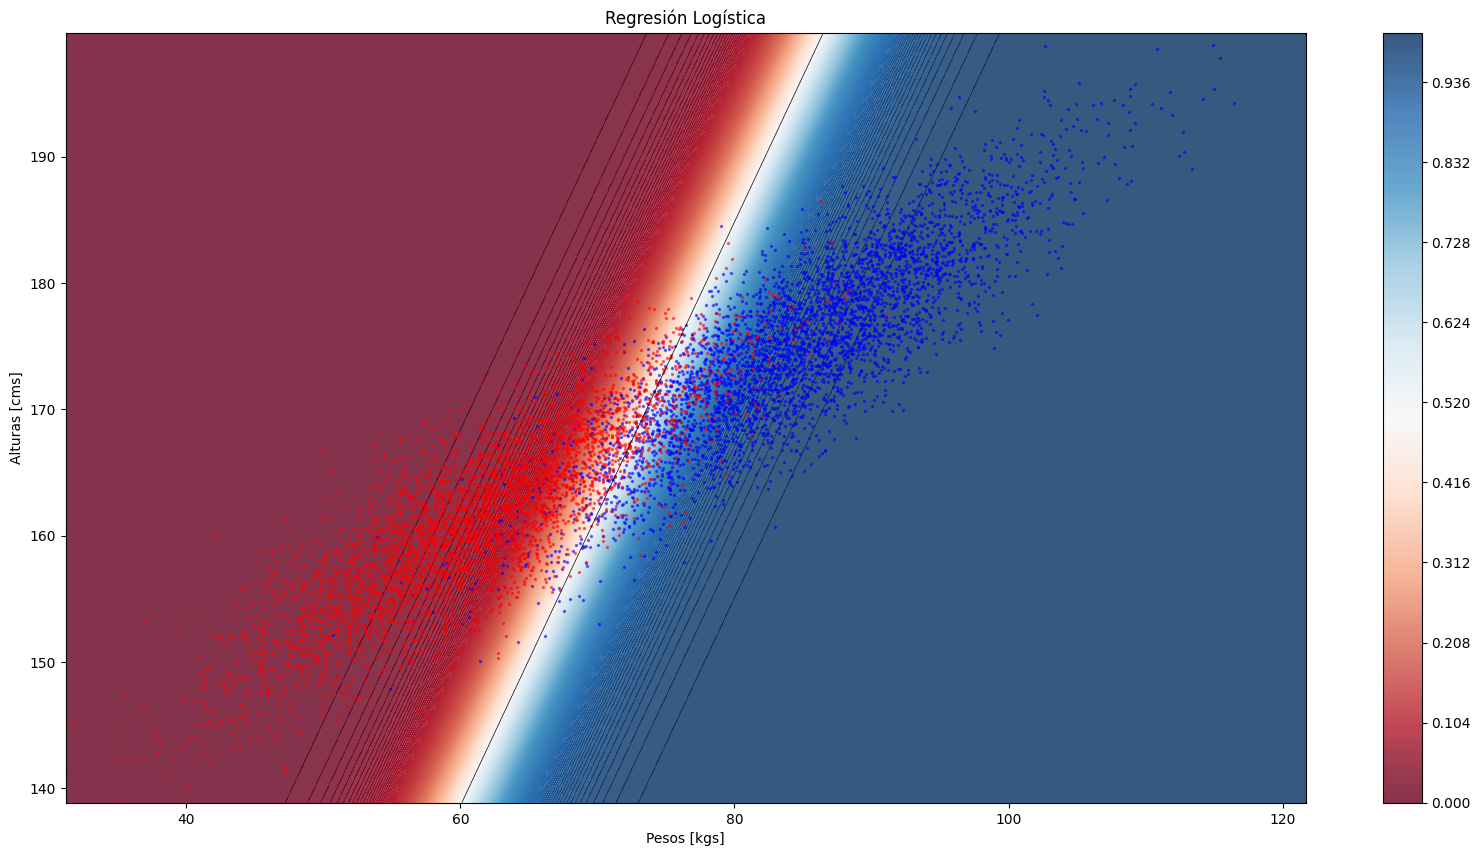

In [29]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_lr, 256, alpha=.8, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
ax.contour(X, Y, Z_lr, (0.5,), colors='k', linewidths=0.5)
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=0.5)
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=0.5)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.title('Regresión Logística')
plt.show()

Se puede observar el umbral de decisión lineal, levemente desplazado a izquierda (corta el eje en 60 mientras que antes era un poco mas)